<a href="https://colab.research.google.com/github/mystlee/2021_5th_MWP_Generator/blob/main/chapter5/ResNet_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 모델 구성, 학습 등을 위한 라이브러리 import   
### torch   
  - pytorch 프레임워크   

### torchvision
  - pytorch에서 vision (영상)에 특화된 라이브러리   

### torch.nn
  - nn = neural network   
  - 딥러닝 관련 라이브러리  
  - fully-connected layer, conv layer 등을 포함  

### torch.nn.functional   
  - 활성화 함수와 같은 딥러닝 관련 함수 라이브러리   
  - Softmax, ReLU 함수와 같은 활성화 함수 등등 포함

### torch.optim
  - 모델 학습을 위한 옵티마이저 라이브러리   
  - SGD, AdaGrad, RMSProp, Adam 등 옵티마이저 포함

### matplotlib.pyplot   
  - figure를 display하기 위한 라이브러리

### numpy
  - python 기본 연산을 돕는 라이브러리

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

## 1. 데이터셋 변환   
모델 입력에 맞게 데이터셋의 format을 변환

In [5]:
# 데이터 변환
transform = transforms.Compose([
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))  # 정규화
])

# CIFAR-10 dataset 로드
train_dataset = datasets.CIFAR10(root = './data',
                                 train = True,
                                 download = True,
                                 transform = transform)
test_dataset = datasets.CIFAR10(root = './data',
                                train = False,
                                download = True,
                                transform = transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size = 128,
                          shuffle = True, num_workers = 2)
test_loader  = DataLoader(test_dataset, batch_size = 100,
                          shuffle = False, num_workers = 2)

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 2. 모델 구조   
모델 구조 작성   
- 일반적으로 class 의 \_\_init\_\_ 함수부분에서 모듈들은 선언하고,
- 그 다음 forward 함수에 전체적인 흐름 작성   
- BasicBlock은 ResNet을 이루는 기본 blcok   
   - conv -> bn -> relu -> conv -> bn -> +connection -> relu   

- ResNet은 BasicBlock을 이용하여 구성

<img src = "https://miro.medium.com/v2/resize:fit:720/format:webp/1*aLvULJeweGPIJYVlLgCydg.png" width = "70%" height = "50%">   

출처: <https://medium.com/operations-research-bit/deep-learning-resnets-08e79e604fa0>   

In [6]:
# BasicBlock 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        # 첫 번째 3x3 conv layer
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size = 3,
                               stride = stride,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 3x3 conv layer
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        # residuial connection
        # input image 또는 feature map
        # 사이즈가 안맞는 경우 다운샘플링 진행
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size = 1,
                          stride = stride,
                          bias = False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # residual connection
        out = F.relu(out)
        return out

# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 초기 conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1,
                               padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        # residual block 정의
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        # classifier
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)  # 첫 블록은 stride 적용
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
        # list 앞에 *은 unpacking 연산으로
        # [[conv block_1], [conv block_2], ..., [conv block_N]]
        # --> [conv block_1, conv block_2, ..., conv block_N]

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # residual block을 차례로 통과
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # average pooling 및 classifier 통과
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# ResNet18 model 생성
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# 모델 초기화 및 디바이스 설정
model = ResNet18()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


## 3-1. 학습 및 테스트 함수 정의   
학습 함수   
- batch 단위로 update 진행
- error와 gradients를 계산하고 업데이트!
- loss뿐만아니라 정확도도 측정

테스트 함수
- 학습 함수와 거의 동일하지만,
- 모델을 업데이트하는 부분이 제외됨

In [7]:
# 학습 함수 정의
def train():
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # feed forward (순전파)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # 역전파 및 가중치 업데이트
        loss.backward() # back propagation을 통한 error 및 gradient 계산
        optimizer.step() # 모델 파라미터 update!

        running_loss += loss.item() # 현재 계산된 loss를 합산
        _, predicted = outputs.max(1) # 정확도 계산을 위해서 추론 진행
        total += targets.size(0) # 정확도 계산을 위한 모수 계산
        correct += predicted.eq(targets).sum().item()

        # 특정 스텝마다 로그 출력 및 손실, 정확도 저장
        if (batch_idx + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            accuracy = 100. * correct / total
            print(f'Step [{batch_idx+1}/{len(train_loader)}], \
                    Loss: {avg_loss:.4f}, \
                    Accuracy: {accuracy:.2f}%')

            # loss와 정확도 저장
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)
            steps.append(batch_idx + 1)

            running_loss = 0.0
            correct = 0
            total = 0
# 테스트 함수
# 학습 함수와 거의 유사하지만, 모델 파라미터를 update하는 과정이 미포함
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

## *(optional) 데이터 샘플들 추론해보기   
데이터로더에서 샘플 몇 개를 추려서 추론

Initialized model inference:


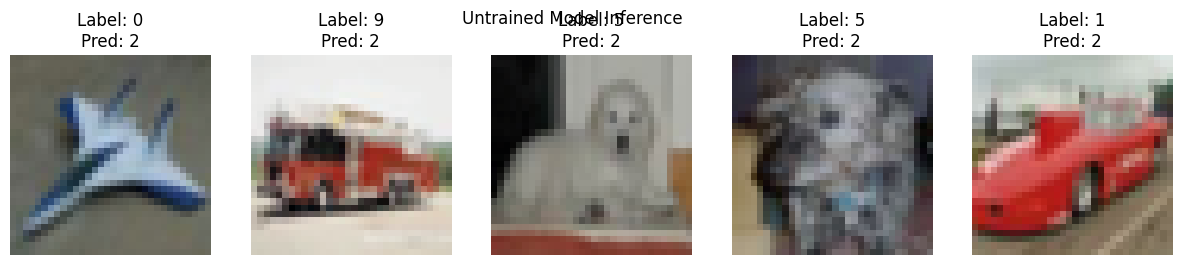

In [8]:
def infer_sample_images(model, num_samples = 5, title='Model Inference'):
    model.eval()
    sample_loader = DataLoader(test_dataset, batch_size = num_samples, shuffle = True)
    dataiter = iter(sample_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = outputs.max(1)

    images = images.cpu().numpy()
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    for idx in range(num_samples):
        image = images[idx]
        image = np.transpose(image, (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        axes[idx].imshow(image)
        axes[idx].set_title(f'Label: {labels[idx].item()}\nPred: {predicted[idx].item()}')
        axes[idx].axis('off')
    plt.suptitle(title)
    plt.show()

# 초기화된 모델로 추론
print("Initialized model inference:")
infer_sample_images(model, title='Untrained Model Inference')

## 3-2. 손실 함수 및 옵티마이저 정의 후 학습 진행

classification task -> cross entropy loss를 사용!
optimizer는 Adam 사용
- [pytorch optimizer] <https://pytorch.org/docs/stable/optim.html>
- SGD, RMSprop 등 다양한 optimizer 활용 가능

Loss와 optimizer를 이용해서 모델 학습!

In [9]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=5e-4)

num_epochs = 10  # epoch 설정
log_interval = 100  # log를 출력할 step 간격

# loss과 정확도를 저장할 list
train_losses = []
train_accuracies = []
steps = []
# 전체 테스트 정확도를 저장할 list
test_accuracies = []

# 학습 진행
for epoch in range(1, num_epochs + 1):
    print(f'\nEpoch {epoch}/{num_epochs}')
    train()
    test_accuracy = test()
    test_accuracies.append(test_accuracy)


Epoch 1/10
Step [100/391],                     Loss: 1.7721,                     Accuracy: 35.89%
Step [200/391],                     Loss: 1.3937,                     Accuracy: 48.86%
Step [300/391],                     Loss: 1.2237,                     Accuracy: 55.93%
Test Accuracy: 51.19%

Epoch 2/10
Step [100/391],                     Loss: 1.0175,                     Accuracy: 63.41%
Step [200/391],                     Loss: 0.9422,                     Accuracy: 66.16%
Step [300/391],                     Loss: 0.8822,                     Accuracy: 68.33%
Test Accuracy: 61.02%

Epoch 3/10
Step [100/391],                     Loss: 0.7654,                     Accuracy: 73.24%
Step [200/391],                     Loss: 0.7293,                     Accuracy: 74.13%
Step [300/391],                     Loss: 0.7122,                     Accuracy: 75.17%
Test Accuracy: 71.15%

Epoch 4/10
Step [100/391],                     Loss: 0.6224,                     Accuracy: 78.22%
Step [200/391], 

## 3-3. 모델 학습 결과 그래프로 그려보기   
loss 값 또는 metric (정확도 등등)의 값을 매 step 또는 epoch마다 출력하여 list로 저쟁했다가 확인

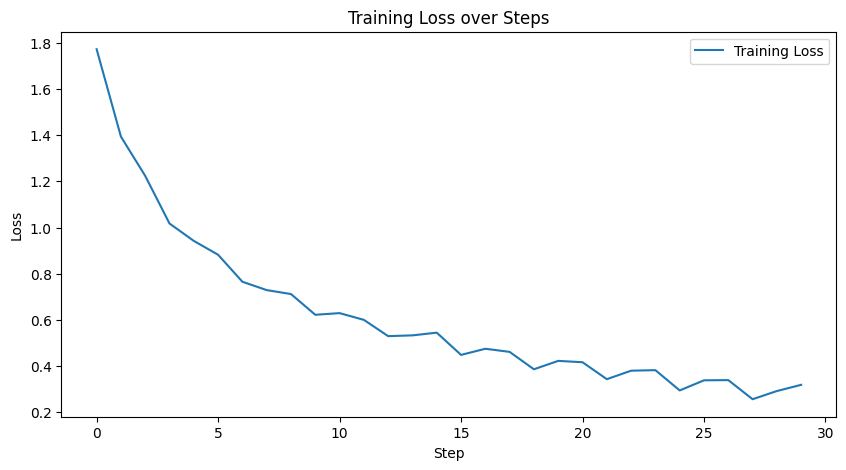

In [10]:
# 손실 그래프 그리기
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.show()

## *(optional) 데이터 샘플들 추론해보기   
데이터로더에서 샘플 몇 개를 추려서 추론


Trained model inference:


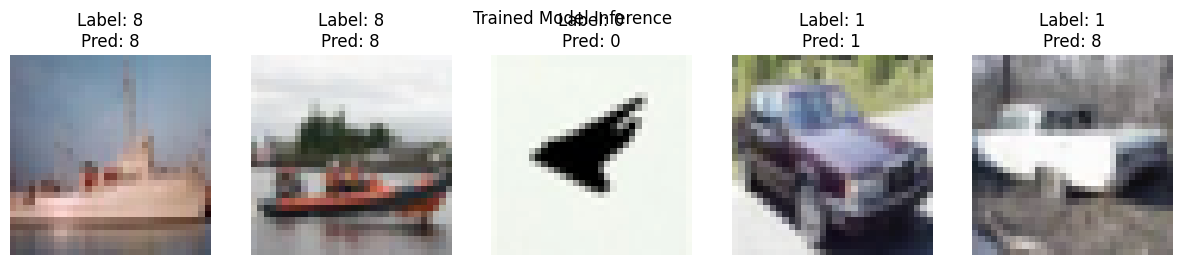

In [ ]:
# 학습된 모델로 추론
print("\nTrained model inference:")
infer_sample_images(model, title='Trained Model Inference')